In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.style.use('dark_background')

In [2]:
fns = {
    40: 'startup_duty_50.csv',
    60: 'startup_duty_70.csv',
    80: 'startup_duty_90.csv',
    100: 'startup_duty_110.csv'
}

In [3]:
def expfit(D, x = None):
    S = [0]
    n = D.shape[0]
    if type(x) is np.ndarray:
        x = x.copy()
        x -= x[0]
    else:
        x = np.arange(n)
        
    for k in range(1, n):
        S.append(S[-1] + (D[k] + D[k - 1]) * (x[k] - x[k - 1]) / 2)

    S = np.array(S)

    A = [[np.sum(x ** 2), np.sum(x * S)],
        [np.sum(x * S), np.sum(S ** 2)]]
    B = [np.sum((D - D[0]) * x), np.sum((D - D[0]) * S)]
    [_, c] = np.linalg.solve(A, B)
    C = [[n, np.sum(np.exp(c * x))],
        [np.sum(np.exp(c * x)), np.sum(np.exp(2 * c * x))]]
    D_ = [np.sum(D), np.sum(D * np.exp(c * x))]
    [a, b] = np.linalg.solve(C, D_)
    
    return (a, b, c)

In [4]:
def loadfit(fn, T = 82.5E-6):
    D = 1 / np.loadtxt(fn)
    x = np.cumsum(1 / D) * T
    return (x, D) + expfit(D, x)

In [5]:
fits = { duty: loadfit(fn, 1E-6) for duty, fn in fns.items() }

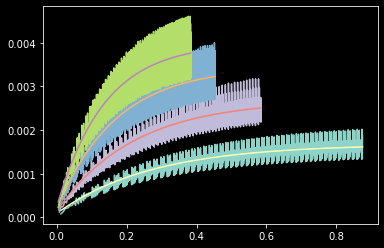

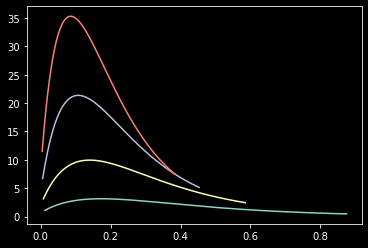

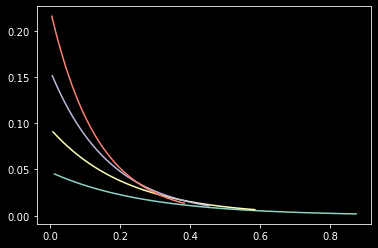

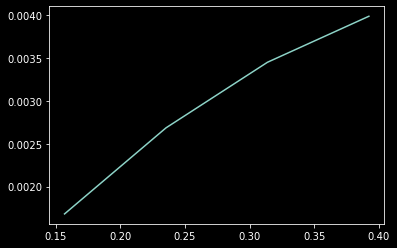

Kv [9809.13806984  258.65367826]


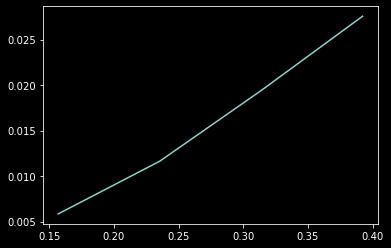

Ki [93028.77894443 -9431.74586229]


In [6]:
TICK2RPM = 1E6 / 42 * 60
TICK2RADPS = 1E6 * 2 * math.pi / 42
IFLY = 0.00005401 # kg-m^2
for duty, (x, D, a, b, c) in fits.items():
    plt.figure(0)
    plt.plot(x, D)
    plt.plot(x, a + b * np.exp(c * x))
    
    plt.figure(1)
    plt.plot(x, b * c * np.exp(c * x) * (b * np.exp(c * x) + a) * IFLY * TICK2RADPS ** 2)
    
    plt.figure(2)
    plt.plot(x, c * b * np.exp(c * x) * IFLY * TICK2RADPS) # rad * m * kg*m / s^2
    # np.polyfit(np.arange(D.shape[0]), 1 / D, 1)

_X, _D, A, B, C = [np.array(a) for a in zip(*fits.values())]
# alpha = -((amax / vmax) + b/m)
# beta = amax - F0 / m
# system: a = (1 - v / vmax) * amax - b' * v - F0'
# => a = -((amax / vmax) + b')*v + (amax - F0')
# => a = alpha * v + beta
# => v = k1*exp(alpha * t) + beta / alpha
# => v = B * exp(C * t) + A
# => 
# A -> beta / alpha
# B -> ~= -beta/alpha (due to v=0 @t=0)
# C -> alpha
DUTY = np.array(list(fits.keys())) / 255
    
plt.figure()
plt.plot(DUTY, A)
plt.show()
print('Kv', np.polyfit(DUTY, A * 1E6, 1))
plt.figure()
plt.plot(DUTY, B * C)
plt.show()
print('Ki', np.polyfit(DUTY, B * C * 1E6, 1))

1593.347704370078 -1264.4091973996235 0.09867936947156418


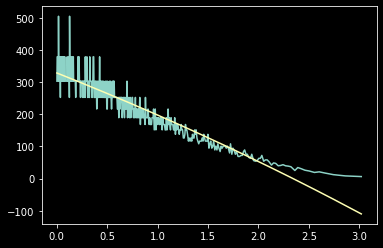

In [10]:
D = 1 / np.loadtxt('slowdown.csv') / (82.5E-6 * 8) # a = -(bv + F0) / m => v = k1 * exp(-b' * t) - F0' / b'
x = np.cumsum(1 / D)
a, b, c = expfit(D, x)
# a, logb = np.polyfit(x, np.log(D), 1)
plt.plot(x, D)
plt.plot(x, b * np.exp(c * x) + a)
print(a, b, c)

0.005156047841010817 24.2949053856942
0.006827461704186149 25.889169876348944
0.008556670855216724 24.956935056410195
0.00978875218480588 23.075776963492682
383.08973199535137 0.0021126703824593707 0.0075822331463048925


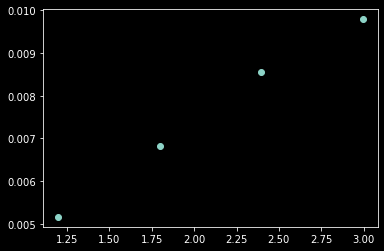

In [9]:
V0 = 7.633
# Bm = 0.96 # b/m friction damping term
Ki = []
alphas = []
T = 82.5E-6
for duty, (_x, _D, a, _b, c) in fits.items():
    V = duty / 255 * V0
    Ki.append(-a * c / V)
    print(Ki[-1], a / V / T / 42 * 60)
    alphas.append(V)

_Kv, Bm = np.polyfit(alphas, Ki, 1)
plt.scatter(alphas, Ki)
print(1 / _Kv, Bm, np.mean(Ki))

array([1.00032569, 1.34702334])